<a href="https://colab.research.google.com/github/sophie55555/Quest/blob/main/2024_1_14_p3_pneumonia_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#구글드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/MyDrive/data/pneumonia.zip'


# 2. 압축 파일 경로 설정
extract_to_path = '/content/drive/MyDrive/data/pneumonia'


# 3. 압축 해제
import zipfile
import os

os.makedirs(extract_to_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset extracted to: {extract_to_path}")

Dataset extracted to: /content/drive/MyDrive/data/pneumonia


3-1. 프로젝트 : 폐렴 진단기 성능개선
조금 전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀 더 분발해야겠죠?

그렇다면 우리는 조금 전까지의 실습 과정을 되짚어보면서, 어떤 점을 더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 더 성능을 향상시켜 보려고 합니다.

우선 주요 라이브러리 버전을 확인해 봅시다.

In [ ]:
import tensorflow

print(tensorflow.__version__)

2.17.1


Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

프로젝트에서 사용할 패키지 목록입니다.

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

앞으로 필요한 변수들을 생성합니다.

In [ ]:

# 2. 데이터 경로 설정
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/data/pneumonia'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

# 경로가 제대로 설정되었는지 확인
print("ROOT_PATH:", ROOT_PATH)
print("TRAIN_PATH:", TRAIN_PATH)

ROOT_PATH: /content/drive/MyDrive/data/pneumonia
TRAIN_PATH: /content/drive/MyDrive/data/pneumonia/chest_xray/train/*/*


In [ ]:
import os

print(os.listdir('/content/drive/MyDrive/data/pneumonia'))  # 'chest_xray' 폴더가 보이는지 확인
print(os.listdir('/content/drive/MyDrive/data/pneumonia/chest_xray'))  # 'train', 'val', 'test' 폴더가 보이는지 확인

['chest_xray']
['__MACOSX', 'chest_xray', 'test', 'train', 'val']


데이터 가져오기 import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠. 아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


데이터 가져오기 import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.
아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [ ]:
# Step 2. 데이터 준비 및 Augmentation
def process_path(filepath):
    # 파일 경로에서 라벨 추출
    label = tf.strings.split(filepath, os.sep)[-2]
    label = tf.where(label == 'PNEUMONIA', 1, 0)

    # 이미지 읽기 및 디코딩
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    return img, label

In [ ]:
# Augmentation 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    return image, label


=== Step 2: Image Processing Check ===
Processed image shape: (180, 180, 3)
Image value range: 0.00 ~ 1.00
Label: Normal


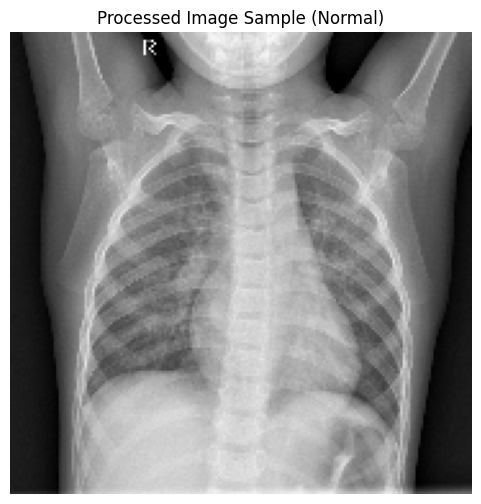

In [ ]:
# 1. process_path 함수 정의
def process_path(filepath):
    label = tf.strings.split(filepath, os.sep)[-2]
    label = tf.where(label == 'PNEUMONIA', 1, 0)

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    return img, label

# 2. 이미지 처리 확인 함수
def check_processed_image():
    print("\n=== Step 2: Image Processing Check ===")
    sample_filepath = train_filenames[0]
    img, label = process_path(sample_filepath)
    print(f"Processed image shape: {img.shape}")
    print(f"Image value range: {tf.reduce_min(img).numpy():.2f} ~ {tf.reduce_max(img).numpy():.2f}")
    print(f"Label: {'Pneumonia' if label == 1 else 'Normal'}")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Processed Image Sample ({'Pneumonia' if label == 1 else 'Normal'})")
    plt.axis('off')
    plt.show()

# 함수 실행하여 확인
check_processed_image()

# 3. 그 후에 데이터셋 생성
def create_dataset(filenames, augment_data=False, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    ...

# 데이터셋 생성
train_dataset = create_dataset(train_filenames, augment_data=True)
val_dataset = create_dataset(val_filenames, augment_data=False)
test_dataset = create_dataset(test_filenames, augment_data=False, shuffle=False)

In [ ]:
# 데이터셋 생성 함수
def create_dataset(filenames, augment_data=False, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(1000)

    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
# 데이터셋 생성
train_dataset = create_dataset(train_filenames, augment_data=True)
val_dataset = create_dataset(val_filenames, augment_data=False)
test_dataset = create_dataset(test_filenames, augment_data=False, shuffle=False)

In [ ]:
def check_dataset_shapes():
    print("\n=== 데이터셋 shape 확인 ===")
    for images, labels in train_dataset.take(1):
        print(f"배치 이미지 shape: {images.shape}")
        print(f"배치 레이블 shape: {labels.shape}")
        print(f"레이블 샘플: {labels.numpy()[:5]}")

check_dataset_shapes()


=== 데이터셋 shape 확인 ===
배치 이미지 shape: (16, 180, 180, 3)
배치 레이블 shape: (16,)
레이블 샘플: [0 0 0 0 0]



=== Step 3: 데이터 분포 시각화 ===


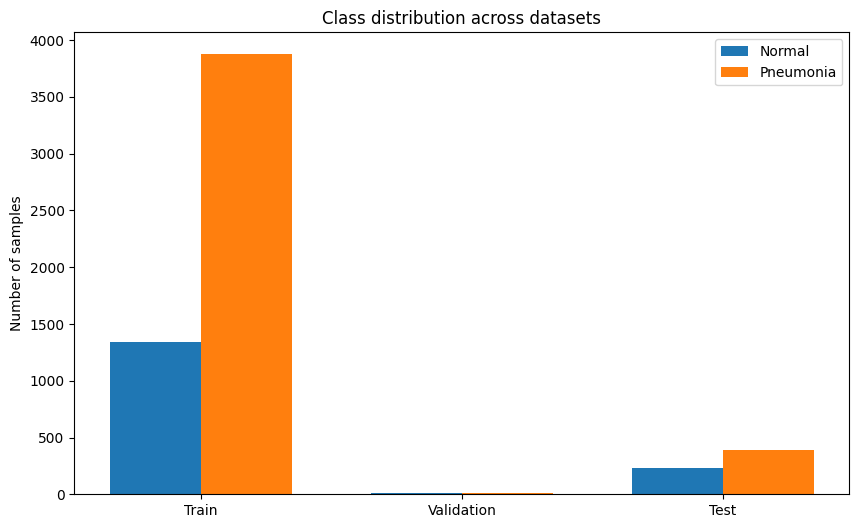


데이터 분포:
Train - Normal: 1341, Pneumonia: 3875
Train 비율 (Normal:Pneumonia) = 0.35:1
Validation - Normal: 8, Pneumonia: 8
Validation 비율 (Normal:Pneumonia) = 1.00:1
Test - Normal: 234, Pneumonia: 390
Test 비율 (Normal:Pneumonia) = 0.60:1


In [ ]:
# Step 3. 데이터 분포 시각화
def visualize_data_distribution():
    print("\n=== Step 3: 데이터 분포 시각화 ===")

    def count_samples(dataset):
        normal = sum(1 for _, label in dataset.unbatch() if label.numpy() == 0)
        pneumonia = sum(1 for _, label in dataset.unbatch() if label.numpy() == 1)
        return normal, pneumonia

    train_normal, train_pneumonia = count_samples(train_dataset)
    val_normal, val_pneumonia = count_samples(val_dataset)
    test_normal, test_pneumonia = count_samples(test_dataset)

    data = {
        'Train': [train_normal, train_pneumonia],
        'Validation': [val_normal, val_pneumonia],
        'Test': [test_normal, test_pneumonia]
    }

    plt.figure(figsize=(10, 6))
    x = np.arange(len(data))
    width = 0.35

    plt.bar(x - width/2, [d[0] for d in data.values()], width, label='Normal')
    plt.bar(x + width/2, [d[1] for d in data.values()], width, label='Pneumonia')

    plt.xticks(x, data.keys())
    plt.ylabel('Number of samples')
    plt.title('Class distribution across datasets')
    plt.legend()
    plt.show()

    print("\n데이터 분포:")
    for dataset_name, (normal, pneumonia) in data.items():
        print(f"{dataset_name} - Normal: {normal}, Pneumonia: {pneumonia}")
        print(f"{dataset_name} 비율 (Normal:Pneumonia) = {normal/pneumonia:.2f}:1")

visualize_data_distribution()

In [ ]:
# Step 4. ResNet-18 구현
def create_resnet18():
    def residual_block(x, filters, stride=1):
        shortcut = x

        x = layers.Conv2D(filters, 3, stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, 3, 1, padding='same')(x)
        x = layers.BatchNormalization()(x)

        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([shortcut, x])
        x = layers.ReLU()(x)
        return x

    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))

    x = layers.Conv2D(64, 7, 2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, 2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, 2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, 2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, 2)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

# 모델 생성 및 구조 확인
model = create_resnet18()
print("\n=== Step 4: 모델 구조 확인 ===")
model.summary()


=== Step 4: 모델 구조 확인 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 90, 90, 64)     │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 90, 90, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 90, 90, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 45, 45, 64)     │              0 │ re_lu_17[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 45, 45, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 45, 45, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 45, 45, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 45, 45, 64)     │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 45, 45, 64)     │              0 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ re_lu_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 45, 45, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 45, 45, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ re_lu_20[0][0]         │
├──────────────────────

 Total params: 11,191,425 (42.69 MB)

 Trainable params: 11,181,825 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
# Step 5. 데이터 불균형 처리
def calculate_class_weights():
    print("\n=== Step 5: 클래스 가중치 계산 ===")
    pos = sum(1 for _, label in train_dataset.unbatch() if label.numpy() == 1)
    neg = sum(1 for _, label in train_dataset.unbatch() if label.numpy() == 0)
    total = pos + neg

    weights = {0: total/(2*neg), 1: total/(2*pos)}
    print(f"클래스 가중치: {weights}")
    return weights

class_weight = calculate_class_weights()


=== Step 5: 클래스 가중치 계산 ===


In [34]:
# 콜백에서 early_stopping 제거
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print(f"\nEpoch {epoch+1} 결과:")
        for metric, value in logs.items():
            print(f"{metric}: {value:.4f}")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[TrainingProgressCallback()]  # early_stopping 제거
)


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9309 - auc_4: 0.8676 - loss: 0.2035
Epoch 1 결과:
accuracy: 0.9461
auc_4: 0.9836
loss: 0.1552
val_accuracy: 0.5000
val_auc_4: 0.5000
val_loss: 4.0508
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 126ms/step - accuracy: 0.9309 - auc_4: 0.8679 - loss: 0.2034 - val_accuracy: 0.5000 - val_auc_4: 0.5000 - val_loss: 4.0508
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8795 - auc_4: 0.8386 - loss: 0.5299
Epoch 2 결과:
accuracy: 0.9350
auc_4: 0.9730
loss: 0.2080
val_accuracy: 0.6250
val_auc_4: 0.9688
val_loss: 1.2792
326/326 ━━━━━━━━━━━━━━━━━━━━ 57s 123ms/step - accuracy: 0.8796 - auc_4: 0.8390 - loss: 0.5289 - val_accuracy: 0.6250 - val_auc_4: 0.9688 - val_loss: 1.2792
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8645 - auc_4: 0.8492 - loss: 0.6299
Epoch 3 결과:
accuracy: 0.9348
auc_4: 0.9693
loss: 0.2289
val_accuracy: 0.8750
val_auc_4: 0.9844
val_loss: 0.2576
326/326 ━━━━━━━━━━━━━━━━━━━━ 84s 132ms/s


=== Step 7: 모델 평가 ===
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.4681 - auc_4: 0.5886 - loss: 1.4634

Test Accuracy: 0.7308
Test AUC: 0.9081


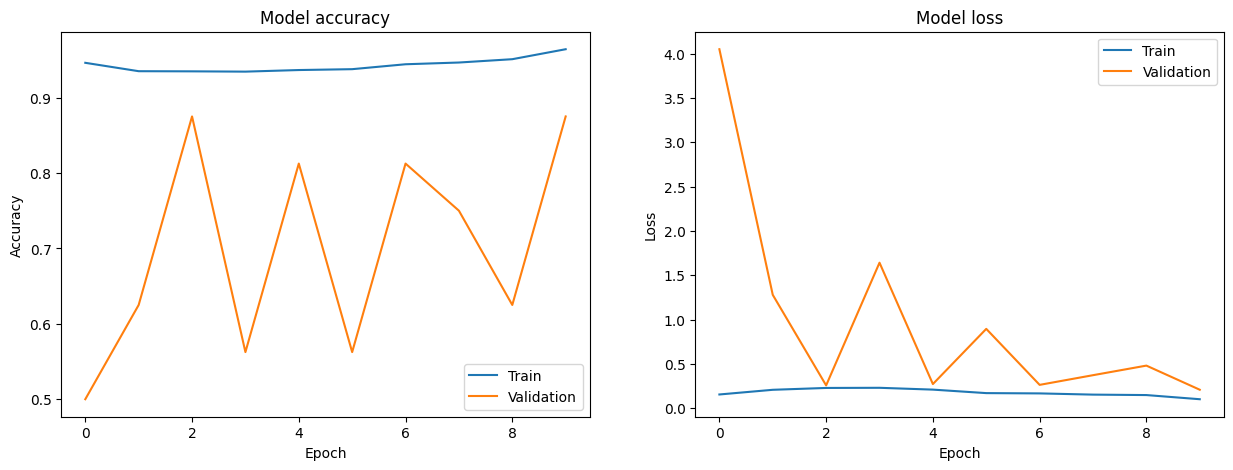

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step


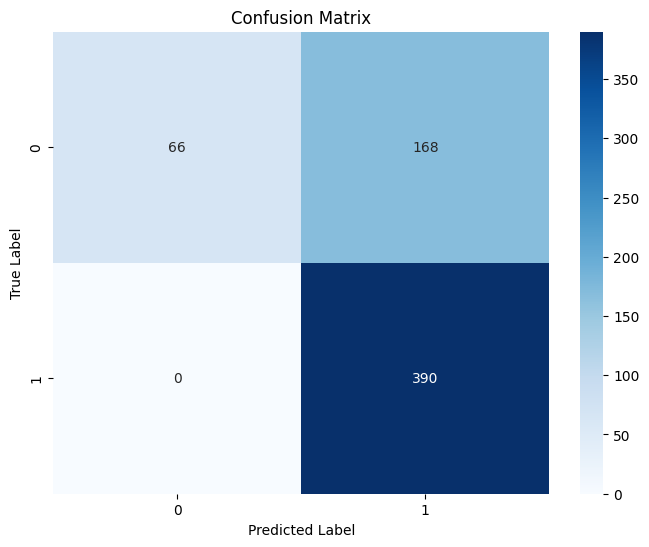


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       234
           1       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.85      0.64      0.63       624
weighted avg       0.81      0.73      0.68       624



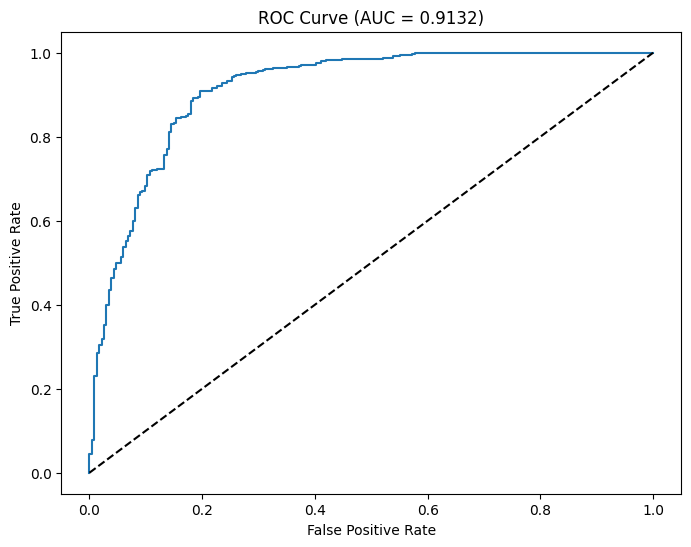

In [35]:
# Step 7. 결과 확인 및 시각화
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns


def evaluate_model():
    print("\n=== Step 7: 모델 평가 ===")

    # 테스트 세트 평가
    test_loss, test_accuracy, test_auc = model.evaluate(test_dataset)
    print(f'\nTest Accuracy: {test_accuracy:.4f}')
    print(f'Test AUC: {test_auc:.4f}')

    # 학습 곡선 시각화
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # Confusion Matrix
    y_pred = model.predict(test_dataset)
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_true = np.concatenate([y for _, y in test_dataset], axis=0)

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 분류 리포트
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred_classes))

    # ROC 커브
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {auc(fpr, tpr):.4f})')
    plt.show()

evaluate_model()


=== 예측 결과 시각화 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


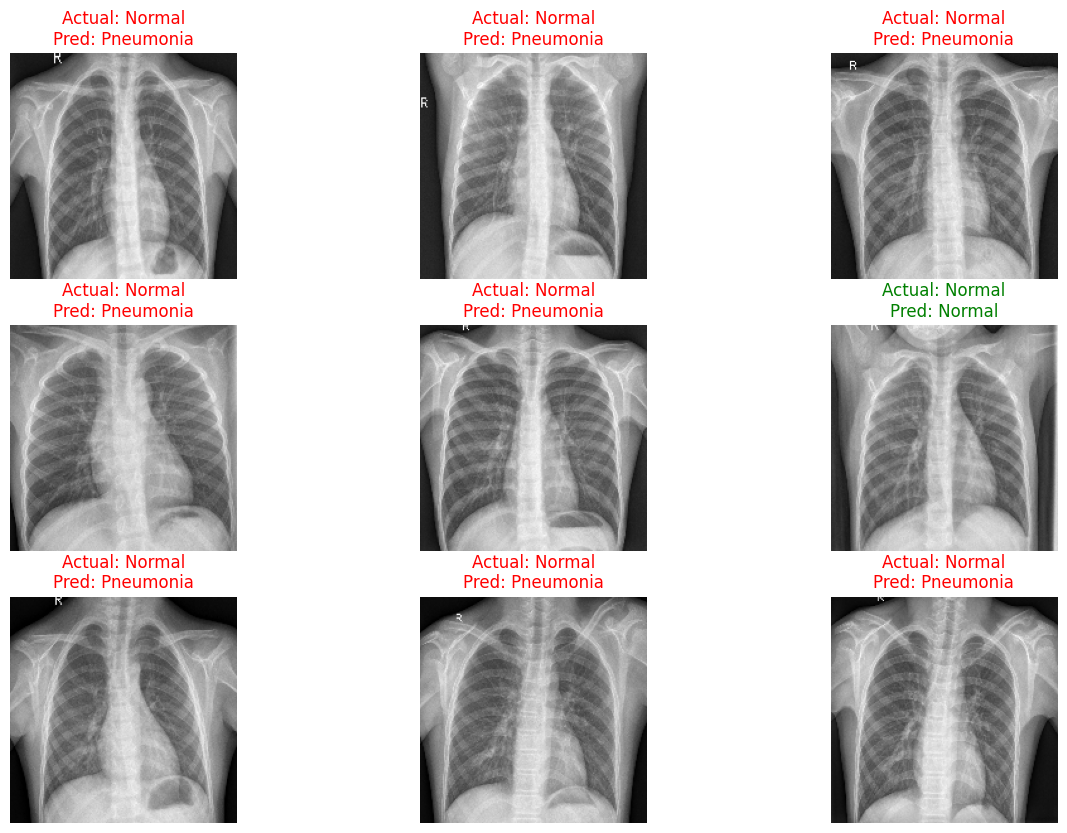

In [36]:
# 예측 샘플 시각화
def visualize_predictions():
    print("\n=== 예측 결과 시각화 ===")
    plt.figure(figsize=(15, 10))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)

        for i in range(min(9, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            actual = "Pneumonia" if labels[i] == 1 else "Normal"
            pred = "Pneumonia" if predictions[i] > 0.5 else "Normal"
            color = 'green' if actual == pred else 'red'
            plt.title(f'Actual: {actual}\nPred: {pred}', color=color)
            plt.axis('off')

    plt.show()

visualize_predictions()

회고:
epoch 하는 도중 자꾸 중지되었음.
callback는 사용하되 early_stopping은 제거하였음.